# Importing files necessary for the code

In [1]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib as mpl
import seaborn as sns
import datetime as dt
import numpy as np
import pandas as pd
import os
from google.cloud import bigquery
from google.oauth2 import service_account
from scipy.stats.mstats import zscore
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest 
from datetime import datetime,tzinfo
import scipy, json, csv, time, pytz
from sklearn.metrics import silhouette_samples, silhouette_score
from pytz import timezone
seed = 135
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Reading the Data

In [2]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS']="assistant1-366df-b820599fde13.json"
customer = bigquery.Client()

# Query to transfer the date records into a dataframe

In [3]:
chunk_1 = """
SELECT 
   DATE(TIMESTAMP_MILLIS(timestamp)) AS Date,
   COUNT(transactions) AS Transactions
FROM `bigquery-public-data.bitcoin_blockchain.blocks`
GROUP BY date
HAVING date >= '2011-08-12' AND date <= '2020-08-12'
ORDER BY date
"""
job_1 = customer.query(chunk_1)
iter = job_1.result(timeout=30)
rows_1 = list(iter)
df_1 = pd.DataFrame(data=[list(x.values()) for x in rows_1], columns=list(rows_1[0].keys()))

# Query to transfer the Output_Satoshis, Blocks, Transaction records into another dataframe and then merging it with date dataframe as "result"

In [4]:
chunk_2 = """
SELECT
  o.Date,
  COUNT(o.block) AS Blocks,
  SUM(o.output_price) AS Output_Satoshis
FROM (
  SELECT
    DATE(TIMESTAMP_MILLIS(timestamp)) AS Date,
    output.output_satoshis AS output_price,
    block_id AS block
  FROM
    `bigquery-public-data.bitcoin_blockchain.transactions`,
    UNNEST(outputs) AS output ) AS o
GROUP BY
  o.date
HAVING o.date >= '2011-08-12' AND date <= '2020-08-12'
ORDER BY o.date, blocks
"""
job_2 = customer.query(chunk_2)
iter_2 = job_2.result(timeout=30)
rows_2 = list(iter_2)
df_2 = pd.DataFrame(data=[list(x.values()) for x in rows_2], columns=list(rows_2[0].keys()))
df_2["Output_Satoshis"]= df_2["Output_Satoshis"].apply(lambda x: float(x/100000000))
result = pd.merge(df_1,df_2[['Date', 'Blocks', 'Output_Satoshis']],on='Date')
data = result[['Output_Satoshis','Blocks','Transactions']]
outliers_fraction=0.05
scaler = StandardScaler()
scaled_version = scaler.fit_transform(data)
data = pd.DataFrame(scaled_version)

# Formatting date coloumn, feature engineering using PCA and fitting the data to obtain an elbow curve (with visualization)

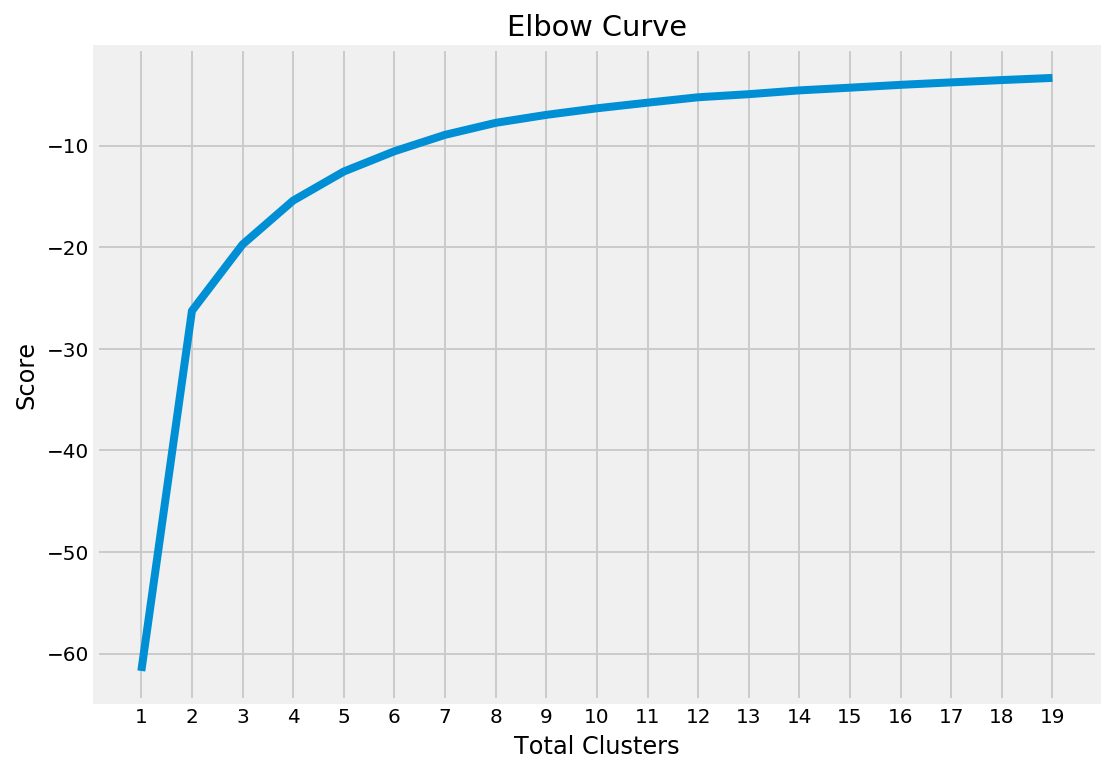

In [5]:
data_original = data.copy()
data_original = data_original.reset_index(drop=True)
data_original[:] = MinMaxScaler().fit_transform(data_original[:])
pca = PCA(n_components=2)
pca.fit(data_original)
pca_data = pca.transform(data_original)
pca_data = pd.DataFrame(pca_data)
num_clusters = range(1, 20)
kmeans = [KMeans(n_clusters=i, random_state=seed).fit(pca_data) for i in num_clusters]
scores = [kmeans[i].score(pca_data) for i in range(len(kmeans))]
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(num_clusters, scores, linewidth = 4)
plt.xticks(num_clusters)
plt.xlabel('Total Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

# Fitting the data and calling KMeans method from sklearn and experimenting with cluster values for 3, 4 and 5- according to the values obtained in the elbow curve.

In [6]:
clust_num = 3
kmeanzz = KMeans(n_clusters=clust_num, random_state=seed)
kmeanzz.fit(pca_data)
kmeanzz.predict(pca_data)
labelz = kmeanzz.labels_
silhouette_avg = silhouette_score(pca_data, labelz)
print("For n_clusters =", 3,"The average silhouette_score is :", silhouette_avg)
best_clust = 4
km = KMeans(n_clusters=best_clust, random_state=seed)
km.fit(pca_data)
km.predict(pca_data)
labels = km.labels_
silhouette_avg = silhouette_score(pca_data, labels)
print("For n_clusters =", 4,"The average silhouette_score is :", silhouette_avg)
best_cluster_ = 5
km_ = KMeans(n_clusters=best_cluster_, random_state=seed)
km_.fit(pca_data)
km_.predict(pca_data)
labels_1 = km_.labels_
silhouette_avg = silhouette_score(pca_data, labels_1)
print("For n_clusters =", 5,"The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.4313199628793064
For n_clusters = 4 The average silhouette_score is : 0.3681224383311087
For n_clusters = 5 The average silhouette_score is : 0.3934254106934024


# Visualization for cluster value= 3

Text(0.5, 1.0, 'Clusters based on K means (3)')

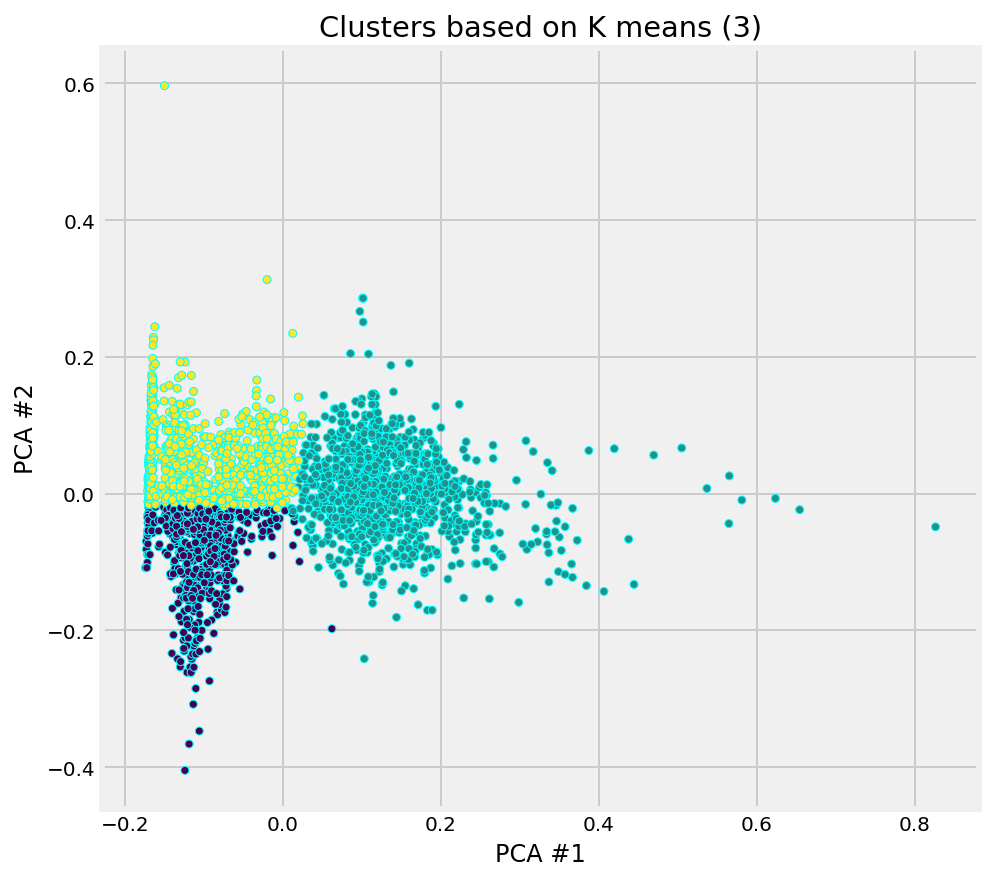

In [7]:
fig = plt.figure(1, figsize=(7,7))
plt.scatter(pca_data.iloc[:,0], pca_data.iloc[:,1], c=labelz.astype(np.float), edgecolor="cyan", s=16)
plt.xlabel('PCA #1')
plt.ylabel('PCA #2')
plt.title('Clusters based on K means (3)')

# Visualization for cluster value= 4

Text(0.5, 1.0, 'Clusters based on K means (4)')

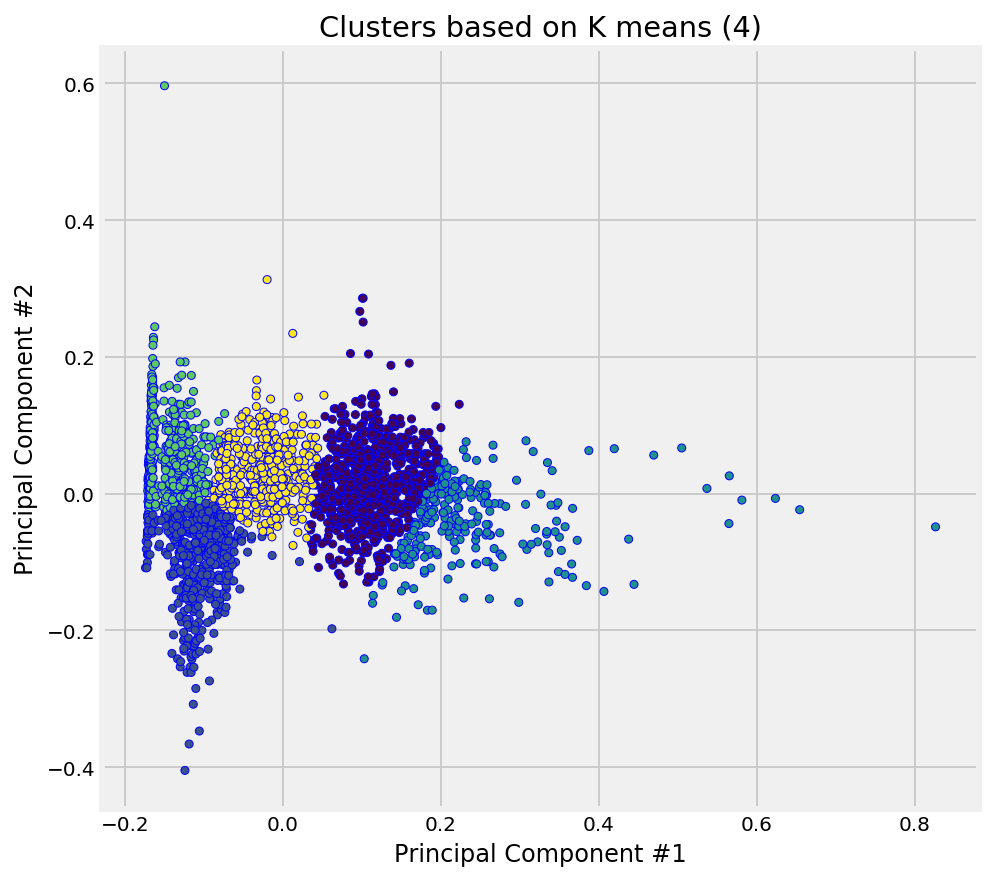

In [8]:
fig = plt.figure(1, figsize=(7,7))
plt.scatter(pca_data.iloc[:,0], pca_data.iloc[:,1], c=labels_1.astype(np.float), edgecolor="blue", s=16)
plt.xlabel('Principal Component #1')
plt.ylabel('Principal Component #2')
plt.title('Clusters based on K means (4)')

In [9]:
pca_data.loc[0]
mod = kmeans[clust_num-1]
pca_data['Principal Component 1'] = pca_data[0]
pca_data['Principal Component 2'] = pca_data[1]
pca_data.drop(columns = [0, 1], inplace=True)

# Implemented a distance method to find the nearest centroids and marking the farthest points as outliers.

Text(0.5, 1.0, 'Anomaly prediction using KMeans:')

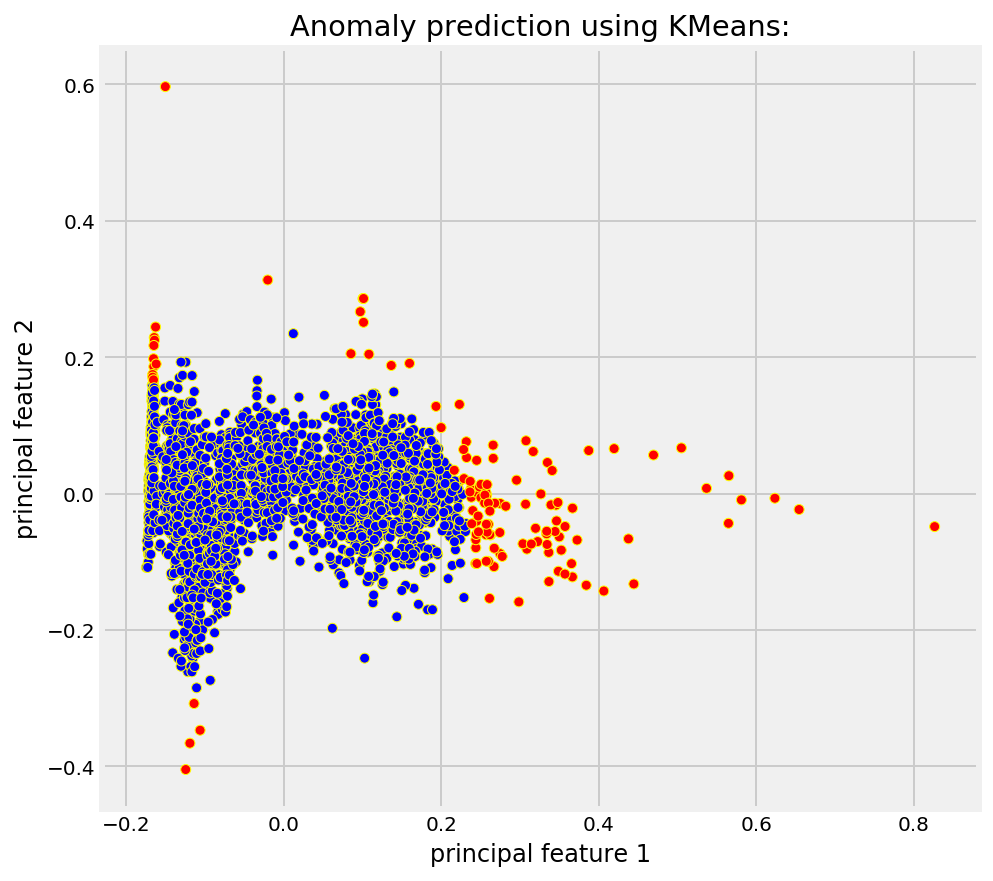

In [10]:
def optimalDistance(data, model):
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return distance
outliers_fraction = 0.05
distance = optimalDistance(pca_data, kmeans[clust_num-1])
distance = pd.Series(distance)
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
result['anomaly_kmeans'] = (distance >= threshold).astype(int)
colors = {0:'blue', 1:'red'}
plt.figure(figsize=(7,7))
plt.scatter(pca_data.iloc[:,0], pca_data.iloc[:,1], c=result["anomaly_kmeans"].apply(lambda x: colors[x]), edgecolor='yellow', s=25)
plt.xlabel('principal feature 1')
plt.ylabel('principal feature 2')
plt.title('Anomaly prediction using KMeans:')

# Final Result

In [11]:
result['anomaly_kmeans'].value_counts()

0    2458
1     129
Name: anomaly_kmeans, dtype: int64

# Visualizations for Anomalies in Total Transactions, Blocks and Satoshis against Total days

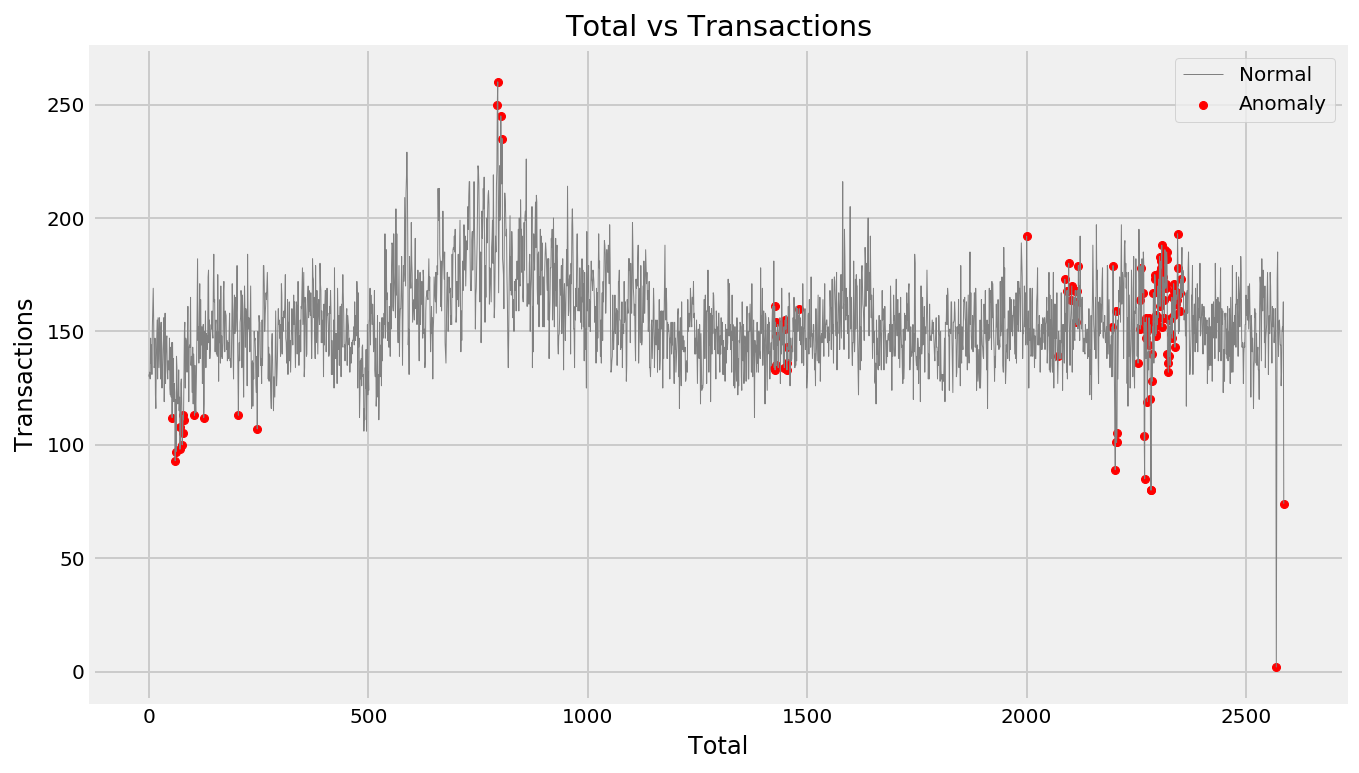

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
a = result.loc[result['anomaly_kmeans'] == 1]
ax.plot(result['Transactions'], color='gray', label = 'Normal', linewidth=0.5)
ax.scatter(a.index ,a['Transactions'], color='red', label = 'Anomaly', s=16)
plt.legend()
plt.title("Total vs Transactions")
plt.xlabel('Total')
plt.ylabel('Transactions')
plt.show()

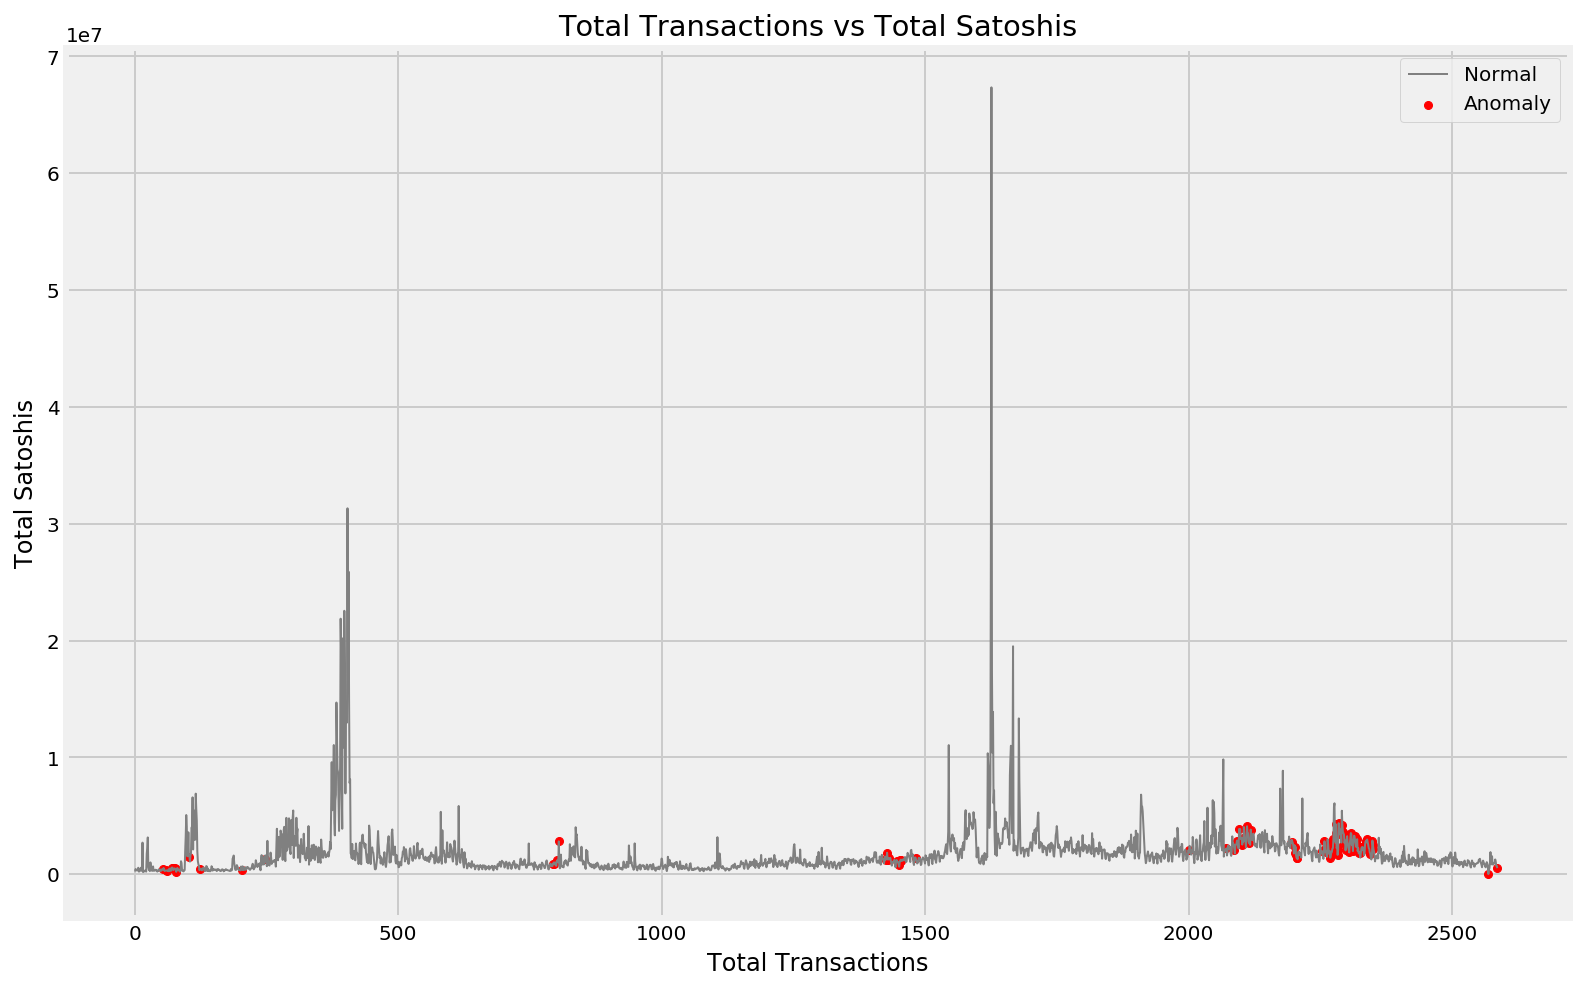

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
a = result.loc[result['anomaly_kmeans'] == 1]
ax.plot(result['Output_Satoshis'], color='gray', label = 'Normal', linewidth=1)
ax.scatter(a.index ,a['Output_Satoshis'], color='red', label = 'Anomaly', s=16)
plt.legend()
plt.title("Total Transactions vs Total Satoshis")
plt.xlabel('Total Transactions')
plt.ylabel('Total Satoshis')
plt.show()

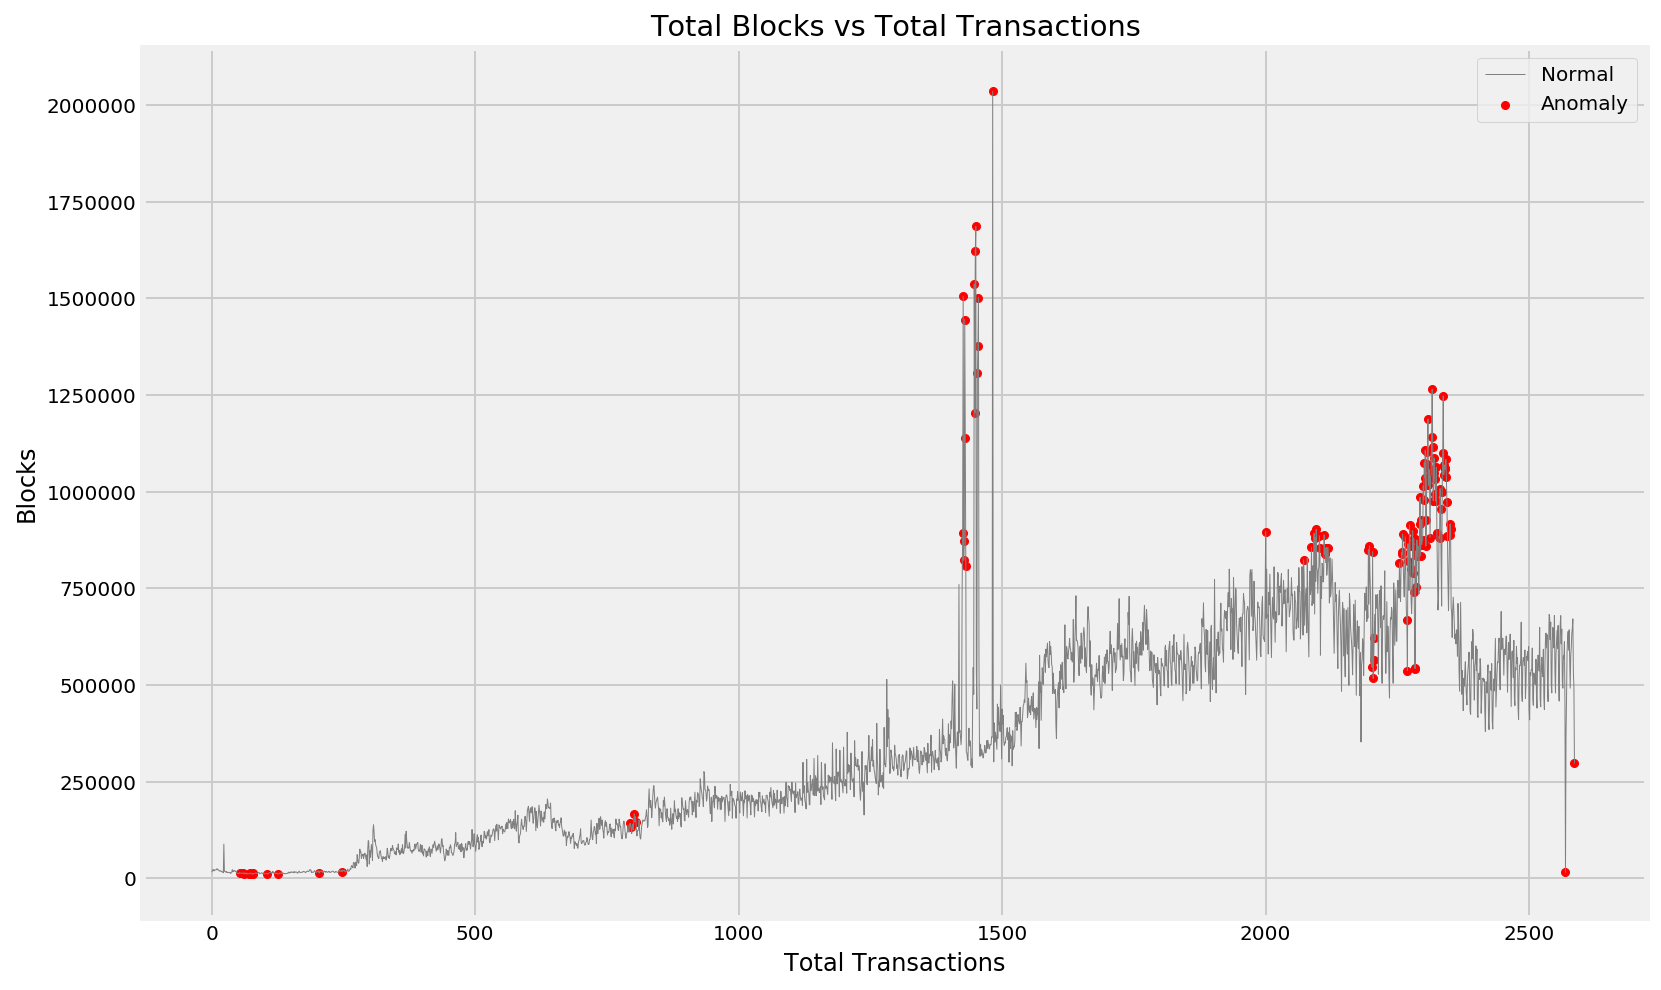

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
a = result.loc[result['anomaly_kmeans'] == 1]
ax.plot(result['Blocks'], color='gray', label = 'Normal', linewidth=0.5)
ax.scatter(a.index ,a['Blocks'], color='red', label = 'Anomaly', s=16)
plt.legend()
plt.title("Total Blocks vs Total Transactions")
plt.xlabel('Total Transactions')
plt.ylabel('Blocks')
plt.show()